In [1]:
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ─── Load Dictionary of Weight Matrices ───────────────────────────────────────
with open('/home/maria/LuckyMouse4/data/visp_significant_neuron_weights.pkl', 'rb') as f:
    data = pickle.load(f)  # Dict: neuron_idx → (n_tasks, D) weight matrix

# ─── Stack All Weight Vectors into a Single Matrix ────────────────────────────
all_weights = []
neuron_ids = []

for neuron_id, matrix in data.items():
    all_weights.append(matrix)
    neuron_ids.extend([neuron_id] * len(matrix))

X = np.vstack(all_weights)            # Shape: (n_total_tasks, D)
neuron_ids = np.array(neuron_ids)    # Shape: (n_total_tasks,)

print(f"Total weight vectors: {X.shape[0]} (from {len(data)} neurons)")

Total weight vectors: 166200 (from 831 neurons)


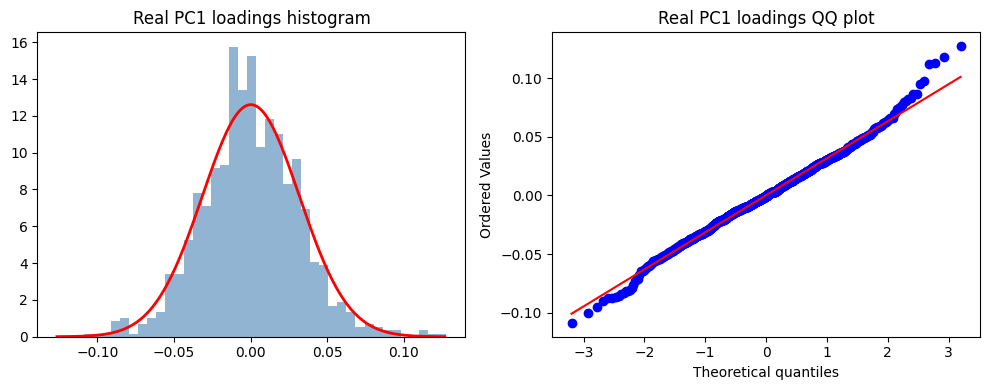

=== Real PC1 loadings ===
mean: 9.301186767660879e-05
std: 0.031638463002074006
Shapiro-Wilk stat: 0.9940352439880371
Shapiro-Wilk p: 0.0005170756485313177
KS stat: 0.025302649386708925
KS p: 0.5354643978776041
Anderson stat: 0.9131922597159701
Anderson crit: [0.574 0.653 0.784 0.914 1.088]
Anderson sig: [15.  10.   5.   2.5  1. ]


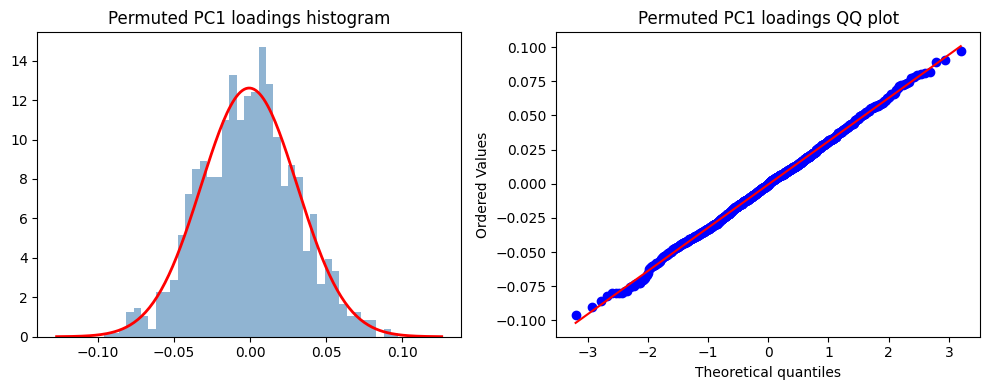


=== Permuted PC1 loadings ===
mean: -0.0005744294362179618
std: 0.03163337954636418
Shapiro-Wilk stat: 0.9987819790840149
Shapiro-Wilk p: 0.7431400418281555
KS stat: 0.015204568823298126
KS p: 0.972229453628025
Anderson stat: 0.250886330686626
Anderson crit: [0.574 0.653 0.784 0.914 1.088]
Anderson sig: [15.  10.   5.   2.5  1. ]

QQ correlation (real vs permuted): 0.9970


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import shapiro, kstest, anderson, norm, probplot

def gaussianity_tests(vec, name=""):
    """Run Gaussianity tests and return results dict."""
    mu, sigma = vec.mean(), vec.std(ddof=1)
    sh_stat, sh_p = shapiro(vec)
    ks_stat, ks_p = kstest(vec, 'norm', args=(mu, sigma))
    ad_res = anderson(vec, dist='norm')
    return {
        "name": name,
        "mean": mu,
        "std": sigma,
        "Shapiro-Wilk stat": sh_stat, "Shapiro-Wilk p": sh_p,
        "KS stat": ks_stat, "KS p": ks_p,
        "Anderson stat": ad_res.statistic,
        "Anderson crit": ad_res.critical_values,
        "Anderson sig": ad_res.significance_level
    }

def plot_hist_qq(vec, mu, sigma, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Histogram with normal PDF overlay
    ax = axes[0]
    ax.hist(vec, bins=40, density=True, alpha=0.6, color='steelblue')
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
    ax.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2)
    ax.set_title(f"{title} histogram")
    # QQ plot
    ax = axes[1]
    probplot(vec, dist="norm", plot=ax)
    ax.set_title(f"{title} QQ plot")
    plt.tight_layout()
    plt.show()

# ==== Run on your data ====
# X should be shape (n_neurons, n_classes)
# Replace this with your real matrix:
# X = ...

pca = PCA(n_components=1).fit(X)
scores_real   = pca.transform(X).ravel()       # UΣ
loadings_real = pca.components_[0].ravel()     # V

# Run tests on loadings (use loadings for semantic interpretation)
results_real = gaussianity_tests(loadings_real, name="Real PC1 loadings")
plot_hist_qq(loadings_real, results_real["mean"], results_real["std"], "Real PC1 loadings")

print("=== Real PC1 loadings ===")
for k, v in results_real.items():
    if k != "name":
        print(f"{k}: {v}")

# ==== Null control: permute X ====
X_perm = X.flatten()[np.random.permutation(X.size)].reshape(X.shape)
pca_perm = PCA(n_components=1).fit(X_perm)
loadings_perm = pca_perm.components_[0].ravel()

results_perm = gaussianity_tests(loadings_perm, name="Permuted PC1 loadings")
plot_hist_qq(loadings_perm, results_perm["mean"], results_perm["std"], "Permuted PC1 loadings")

print("\n=== Permuted PC1 loadings ===")
for k, v in results_perm.items():
    if k != "name":
        print(f"{k}: {v}")

# ==== Optional: QQ correlation real vs permuted ====
q = np.linspace(0, 1, min(len(loadings_real), len(loadings_perm)), endpoint=False)[1:]
real_q = np.quantile(loadings_real, q)
perm_q = np.quantile(loadings_perm, q)
qq_corr = np.corrcoef(real_q, perm_q)[0,1]
print(f"\nQQ correlation (real vs permuted): {qq_corr:.4f}")


In [3]:
from scipy.stats import kurtosis
ex_kurt = kurtosis(loadings_real, fisher=True)  # fisher=True → 0 means Gaussian
print(f"Excess kurtosis: {ex_kurt:.4f}")

Excess kurtosis: 0.7840


In [4]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import kurtosis
import json
from pathlib import Path
import csv
rng = np.random.default_rng(0)

# ---------- Config ----------
K_EXTREMES = 25          # how many classes to list from each tail
N_PERM     = 500         # number of permutations for the null
PERM_MODE  = "by_column" # "by_column" (recommended) or "global"
SAVE_CSV   = True
CSV_PATH   = "pc1_extremes_and_kurtosis.csv"
CONFIG_JSON_PATH = "config.json"  # ViT config with id2label

# ---------- Helpers ----------
def load_id2label(config_path=None, model_name='google/vit-base-patch16-224'):
    # fallback: indices
    id2label = {i: str(i) for i in range(1000)}
    if config_path and Path(config_path).exists():
        with open(config_path, "r") as f:
            cfg = json.load(f)
        if "id2label" in cfg:
            return {int(k): v for k, v in cfg["id2label"].items()}
    try:
        from transformers import AutoConfig
        cfg = AutoConfig.from_pretrained(model_name, local_files_only=True)
        if getattr(cfg, "id2label", None):
            return {int(k): v for k, v in cfg.id2label.items()}
    except Exception:
        pass
    return id2label

def pca_pc1_loadings(X):
    # Center columns like PCA does
    Xc = X - X.mean(axis=0, keepdims=True)
    pca = PCA(n_components=1).fit(Xc)
    return pca.components_[0].ravel()

def permute_X(X, mode="by_column", rng=None):
    rng = np.random.default_rng() if rng is None else rng
    if mode == "global":
        return rng.permutation(X.ravel()).reshape(X.shape)
    elif mode == "by_column":
        Xp = X.copy()
        for j in range(X.shape[1]):
            Xp[:, j] = rng.permutation(Xp[:, j])
        return Xp
    else:
        raise ValueError("mode must be 'by_column' or 'global'")

def extremes_with_labels(vec, id2label, k):
    order = np.argsort(vec)
    neg_idx = order[:k]
    pos_idx = order[-k:][::-1]
    neg = [(int(i), id2label.get(int(i), str(i)), float(vec[i])) for i in neg_idx]
    pos = [(int(i), id2label.get(int(i), str(i)), float(vec[i])) for i in pos_idx]
    return neg, pos

def print_extremes(neg, pos, title="PC1 loadings extremes"):
    print(f"\n=== {title}: most negative (←) ===")
    for i, lab, val in neg:
        print(f"{i:4d}  {val: .6f}  {lab}")
    print(f"\n=== {title}: most positive (→) ===")
    for i, lab, val in pos:
        print(f"{i:4d}  {val: .6f}  {lab}")

def save_extremes_csv(neg, pos, path):
    rows = [("side","index","label","loading")]
    rows += [("negative", i, lab, val) for i, lab, val in neg]
    rows += [("positive", i, lab, val) for i, lab, val in pos]
    with open(path, "w", newline="") as f:
        csv.writer(f).writerows(rows)
    return path

# ---------- Main ----------
# Provide your matrix X: shape = (n_neurons, 1000)
# X = ...

id2label = load_id2label(CONFIG_JSON_PATH)

# Real PC1
pc1_load = pca_pc1_loadings(X)
ex_kurt_real = float(kurtosis(pc1_load, fisher=True))
print(f"Real PC1 excess kurtosis: {ex_kurt_real:.4f}")

# Permutation null
perm_kurts = np.empty(N_PERM, dtype=float)
for b in range(N_PERM):
    Xp = permute_X(X, mode=PERM_MODE, rng=rng)
    pc1p = pca_pc1_loadings(Xp)
    perm_kurts[b] = kurtosis(pc1p, fisher=True)

# Empirical p-value (one-sided: heavy tails > null)
p_emp = (np.sum(perm_kurts >= ex_kurt_real) + 1) / (N_PERM + 1)
print(f"Null mean kurtosis: {perm_kurts.mean():.4f} ± {perm_kurts.std(ddof=1):.4f}")
print(f"Empirical p-value (real kurtosis greater than null): {p_emp:.4g}")

# Extremes with labels
neg, pos = extremes_with_labels(pc1_load, id2label, K_EXTREMES)
print_extremes(neg, pos, title="PC1 loadings")

if SAVE_CSV:
    out = save_extremes_csv(neg, pos, CSV_PATH)
    print(f"\nSaved extremes to {out}")

# Optional: also report how far the real kurtosis is from the null in SD units
z_like = (ex_kurt_real - perm_kurts.mean()) / (perm_kurts.std(ddof=1) + 1e-12)
print(f"Z-like effect size vs null: {z_like:.2f} SD")


Real PC1 excess kurtosis: 0.7811


KeyboardInterrupt: 